In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sys import stdout
import time
import jax
import jax.numpy as jnp
import numpy as np
import openmm.app as app
import openmm.unit as unit
import openmm as mm
from dmff import Hamiltonian, NeighborListFreud
import nglview as nv
import mdtraj
import pandas
from scipy.stats import gaussian_kde
from openmm import app, unit, LangevinMiddleIntegrator, CustomExternalForce
from openmm.app import Simulation, DCDReporter, StateDataReporter
import time

/Users/arminsh/miniconda3/envs/GAD/lib/python3.9/site-packages/dmff/admp/qeq.py:33: UserWarning: jaxopt not found, QEQ cannot be used.
  warnings.warn("jaxopt not found, QEQ cannot be used.")


# Simulation setup

In [2]:
path = os.path.abspath("")
inpcrd = app.AmberInpcrdFile(f"{path}/alanine-dipeptide.inpcrd")
prmtop = app.AmberPrmtopFile(f"{path}/alanine-dipeptide.prmtop")

## Unbiased run

In [3]:
forcefield = app.ForceField(f"{path}/protein.ff14SB.xml")
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)
integrator = mm.LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)

simulation = app.Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
simulation.minimizeEnergy()

In [4]:
simulation.reporters = []
simulation.reporters.append(app.dcdreporter.DCDReporter(f"{path}/traj_openmm_2ns.dcd", 100))
simulation.reporters.append(
    app.statedatareporter.StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    app.statedatareporter.StateDataReporter(
        "scalars_2ns.csv",
        100,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)
start = time.time()
simulation.step(1e6);
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt(f'{path}/time_openmm_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
1000,237.60021520826035,6.67572021484375e-05
2000,350.29378189813644,0.1514451503753662
3000,174.4496409477709,0.26081109046936035
4000,417.2855960506457,0.3600320816040039
5000,334.03265043195637,0.5263938903808594
6000,326.90573975633686,0.6748919486999512
7000,363.02654982948843,0.7723939418792725
8000,355.49245109596876,0.8962838649749756
9000,271.9030005301829,0.9904909133911133
10000,299.9019776612646,1.084104061126709
11000,320.18285061510824,1.180305004119873
12000,310.06833634587286,1.2740778923034668
13000,243.11779587499777,1.3686039447784424
14000,260.1093356012876,1.4654059410095215
15000,324.1093504144023,1.559579849243164
16000,320.5717906297302,1.6525659561157227
17000,401.33845692738265,1.7456510066986084
18000,332.4848178615148,1.8388187885284424
19000,224.1262429493339,1.9338250160217285
20000,181.33599648088665,2.0275909900665283
21000,362.99912872072815,2.121462106704712
22000,360.4006552904013,2.2183680534362793
23000,2

## GADES setup

In [4]:
# Set up the DMFF forcefield for autograd
dmff_ff = Hamiltonian(f"{path}/protein.ff14SB.xml")
params = dmff_ff.paramset
potentials = dmff_ff.createPotential(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)
# load positions from the input file
positions = jnp.array(inpcrd.getPositions(asNumpy=True).value_in_unit(unit.nanometer))
# setup the periodic box
box = jnp.array([[2.0, 0.0, 0.0], [0.0, 2.0, 0.0], [0.0, 0.0, 2.0]])
# setting up the neighbor list
nbList = NeighborListFreud(box, rcut=0.9999, cov_map=potentials.meta["cov_map"])
nbList.allocate(positions)
pairs = nbList.pairs
# define the potential energy function
efunc_pos = lambda pos: potentials.getPotentialFunc()(pos.reshape(-1, 3), box, pairs, dmff_ff.paramset)
# define the gradiant function
grad_vec = jax.grad(efunc_pos)
#define the Hessian function
hessian_vec = jax.hessian(efunc_pos)

## Biased run (no memory)

In [8]:
# Create the system
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)

# Create a custom external force to apply biased forces
biased_force = CustomExternalForce("fx*x+fy*y+fz*z")
biased_force.addPerParticleParameter("fx")  # Add fx as a per-particle parameter
biased_force.addPerParticleParameter("fy")  # Add fy as a per-particle parameter
biased_force.addPerParticleParameter("fz")  # Add fz as a per-particle parameter
system.addForce(biased_force)

# Add a particle for each atom in the system
# Initialize with zero forces
for i in range(system.getNumParticles()):
    biased_force.addParticle(i, [0.0, 0.0, 0.0])  # fx, fy, fz initialized to 0

# Create the integrator and simulation
integrator = LangevinMiddleIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

# Minimize the energy
simulation.minimizeEnergy()

In [5]:
def gad_force_vec(position, grad_func, hess_func):
    '''
    position is Nx3 vector, N = number of atoms
    
    More efficient way to do this by passing forces_u in addition to position so don't have to double compute force_u,
    but annoying to use like this within BAOAB function
    
    Should probably write custom BAOAB to accommodate
    '''
    # unbiased forces
    forces_u = -grad_func(position.flatten())
    
    # biased forces (softened by kappa)
    hess = hess_func(position.flatten())

    w, v = jnp.linalg.eigh(hess)
    w_idx = w.argsort()
    w = w[w_idx]
    v = v[:, w_idx]
    n = v[:,0]

    # Normalize the eigenvector
    n = n / jnp.linalg.norm(n)

    # Compute the biased forces
    forces_b = -jnp.dot(n, forces_u) * n  # Shape: (n_atoms * n_dims,)

    forces_b = forces_b.reshape((position.shape))
    return forces_b

class ForceUpdaterReporter:
    def __init__(self, simulation, biased_force, get_biased_forces, grad_fun, hess_fun, kappa, memory_len, interval):
        self.simulation = simulation
        self.biased_force = biased_force
        self.get_biased_forces = get_biased_forces
        self.grad = grad_fun
        self.hess = hess_fun
        self.kappa = kappa
        self.memory_len = memory_len
        self.interval = interval
        self.N_particles = self.simulation.system.getNumParticles()
        self.force_queue = None # (memory_len, N_particles*3)

    def update_biased_forces(self):
        # get the current state
        state = self.simulation.context.getState(getPositions=True)
        positions = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)

        # compute biased forces using your function
        biased_forces = self.get_biased_forces(positions, self.grad, self.hess).ravel()
   
        if self.simulation.currentStep == self.interval:
            self.force_queue = np.tile(biased_forces, (self.memory_len, 1))
        else:
            self.force_queue = jnp.roll(self.force_queue, -1, axis=0)
            self.force_queue = self.force_queue.at[-1].set(biased_forces)

        # Calculate a weighted average of the last `self.memory_len` bias forces based on their magnitude.
        # get the magnitude of the forces
        avg_weights = jnp.linalg.norm(self.force_queue, axis=1)
        # get the average direction of the forces weighted by their magnitude
        fb_dirs = jnp.average(self.force_queue, axis=0, weights=avg_weights)
        # normalize the average direction vector
        fb_dirs /= jnp.linalg.norm(fb_dirs)
        # move in the direction of the average vector with magnitude of the current bias vector
        biased_forces = fb_dirs*jnp.linalg.norm(biased_forces)
        # dampen the bias with kappa
        biased_forces *= self.kappa
        
        biased_forces = biased_forces.reshape((-1, 3))
        # update the custom external force
        for i in range(system.getNumParticles()):
            self.biased_force.setParticleParameters(i, i, (biased_forces[i, 0], biased_forces[i, 1], biased_forces[i, 2]))
        self.biased_force.updateParametersInContext(simulation.context)
    
    def describeNextReport(self, simulation):
        """
        Return the number of steps until the next report and what data to collect.
        The five `False` values indicate that this reporter does not require any specific data.
        """
        return (self.interval, False, False, False, False, False)

    def report(self, simulation, state):
        """
        This function will be called at intervals specified in describeNextReport().
        It updates the biased forces using the provided function.
        """
        self.update_biased_forces()

In [10]:
# set step count to zero
simulation.context.setStepCount(0)
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj_openmm_gad_2ns.dcd", 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars_gad_2ns.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
bias_reporter = ForceUpdaterReporter(simulation, biased_force, gad_force_vec, grad_fun=grad_vec, hess_fun=hessian_vec, kappa=0.9, memory_len=1, interval=100)
simulation.reporters.append(bias_reporter)

start = time.time()
simulation.step(1e6)
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt('time_openmm_gad_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
1000,220.60856064075003,5.888938903808594e-05
2000,207.88549077461195,1.4983608722686768
3000,326.0017408386876,3.0253548622131348
4000,280.71476484954854,4.670068025588989
5000,465.85858024853724,6.192867994308472
6000,291.46456880264543,7.681756973266602
7000,400.1883433292457,9.154031991958618
8000,352.9645353665296,10.72810411453247
9000,318.305643655017,12.20349407196045
10000,397.47545676768567,13.693216800689697
11000,308.59127323678257,15.276156902313232
12000,352.452016148278,16.794885873794556
13000,358.880773484652,18.270219802856445
14000,395.18179829243456,19.8911349773407
15000,443.1131747822799,21.37669587135315
16000,503.2006648270354,22.85699486732483
17000,307.96092545036294,24.431050777435303
18000,263.34036427854477,25.925431966781616
19000,564.4285724692555,27.409145832061768
20000,264.1661592417426,28.893953800201416
21000,328.1290021516139,30.464738845825195
22000,326.6016362334855,31.92745089530945
23000,294.437418145

## Biased run (10 step memory)

In [22]:
# Create the system
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)

# Create a custom external force to apply biased forces
biased_force = CustomExternalForce("fx*x+fy*y+fz*z")
biased_force.addPerParticleParameter("fx")  # Add fx as a per-particle parameter
biased_force.addPerParticleParameter("fy")  # Add fy as a per-particle parameter
biased_force.addPerParticleParameter("fz")  # Add fz as a per-particle parameter
system.addForce(biased_force)

# Add a particle for each atom in the system
# Initialize with zero forces
for i in range(system.getNumParticles()):
    biased_force.addParticle(i, [0.0, 0.0, 0.0])  # fx, fy, fz initialized to 0

# Create the integrator and simulation
integrator = LangevinMiddleIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

# Minimize the energy
simulation.minimizeEnergy()

In [23]:
# set step count to zero
simulation.context.setStepCount(0)
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj_openmm_gad_mem10_2ns.dcd", 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars_gad_mem10_2ns.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
bias_reporter = ForceUpdaterReporter(simulation, biased_force, gad_force_vec, grad_fun=grad_vec, hess_fun=hessian_vec, kappa=0.9, memory_len=10, interval=100)
simulation.reporters.append(bias_reporter)

start = time.time()
simulation.step(1e6)
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt('time_openmm_gad_mem10_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
1000,273.69973225901583,6.29425048828125e-05
2000,354.17146289841133,1.542220115661621
3000,383.16451694964906,3.180366039276123
4000,331.73772237787574,4.746721029281616
5000,327.5292180487821,6.320433855056763
6000,319.2540016105793,7.882670164108276
7000,296.5308250189989,9.561157941818237
8000,346.5235475807361,11.063143014907837
9000,371.3601945235592,12.618426084518433
10000,338.7305439454268,14.148736000061035
11000,263.27618940208964,15.777873992919922
12000,294.3388995596318,17.28069496154785
13000,414.05295119757085,18.7997989654541
14000,390.7504147752662,20.372130155563354
15000,295.0158562246807,21.891492128372192
16000,427.06183833608577,23.429690837860107
17000,475.6955660194233,24.940590143203735
18000,321.8044592870434,26.492001056671143
19000,339.53639041230787,27.9751980304718
20000,317.8579778182038,29.46045994758606
21000,376.3833252611683,31.028870820999146
22000,296.90606020285253,32.5129189491272
23000,256.89287763229

## Biased run (5 step memory)

In [17]:
# Create the system
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)

# Create a custom external force to apply biased forces
biased_force = CustomExternalForce("fx*x+fy*y+fz*z")
biased_force.addPerParticleParameter("fx")  # Add fx as a per-particle parameter
biased_force.addPerParticleParameter("fy")  # Add fy as a per-particle parameter
biased_force.addPerParticleParameter("fz")  # Add fz as a per-particle parameter
system.addForce(biased_force)

# Add a particle for each atom in the system
# Initialize with zero forces
for i in range(system.getNumParticles()):
    biased_force.addParticle(i, [0.0, 0.0, 0.0])  # fx, fy, fz initialized to 0

# Create the integrator and simulation
integrator = LangevinMiddleIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

# Minimize the energy
simulation.minimizeEnergy()

In [ ]:
# set step count to zero
simulation.context.setStepCount(0)
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj_openmm_gad_mem5_2ns.dcd", 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars_gad_mem5_2ns.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
bias_reporter = ForceUpdaterReporter(simulation, biased_force, gad_force_vec, grad_fun=grad_vec, hess_fun=hessian_vec, kappa=0.9, memory_len=5, interval=100)
simulation.reporters.append(bias_reporter)

start = time.time()
simulation.step(1e6)
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt('time_openmm_gad_mem5_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
1000,274.1448914085764,6.079673767089844e-05
2000,251.11033996132193,1.6394288539886475
3000,261.0406383353827,3.1434738636016846
4000,423.162356761255,4.656141757965088
5000,264.82097456867524,6.169090747833252
6000,337.1677572066799,7.787055730819702
7000,380.01864539185385,9.302857875823975
8000,370.9492678972268,10.791783809661865
9000,352.70255604613857,12.329651832580566
10000,414.04057062523395,13.8451566696167
11000,251.64405754054437,15.353030920028687
12000,376.0716229252818,16.91087794303894
13000,205.14277086761763,18.530595779418945
14000,300.8390613576185,20.005841732025146
15000,180.09626920002466,21.502038955688477
16000,268.55865241915467,23.074288845062256
17000,283.68892724995635,24.570124626159668
18000,338.9889480772951,26.02858591079712
19000,278.44207375260527,27.607813835144043
20000,304.69234569704435,29.127521753311157
21000,376.7348260539531,30.645200729370117
22000,372.4823343747032,32.20097279548645
23000,369.391

## Plots

In [9]:
def plot_ramachandran_contour(traj, num, phi_atoms=None, psi_atoms=None, bins=100):
    """Generate a Ramachandran plot with a contour heatmap.

    Parameters
    ----------
    traj : mdtraj.Trajectory
        An MDTraj trajectory object.
    num : str
        Figure name or identifier.
    phi_atoms : list, optional
        List of atom names to define the phi angle.
    psi_atoms : list, optional
        List of atom names to define the psi angle.
    bins : int, optional
        Number of bins for contour density estimation (default: 100).
    """

    # Compute phi and psi angles
    if phi_atoms is None:
        phis = mdtraj.compute_phi(traj)[1].ravel()
    else:
        phis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, phi_atoms)[1]
        )

    if psi_atoms is None:
        psis = mdtraj.compute_psi(traj)[1].ravel()
    else:
        psis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, psi_atoms)[1]
        )

    # Convert to degrees
    phis = phis * 180 / np.pi
    psis = psis * 180 / np.pi

    # Compute kernel density estimate (KDE)
    values = np.vstack([phis, psis])
    kde = gaussian_kde(values)(values)

    # Create contour plot
    plt.close(num)
    fig, ax = plt.subplots(figsize=(7, 5))
    sc = ax.scatter(phis, psis, c=kde, cmap="viridis", s=5)
    ax.axvline(0, color="k", linestyle="--", lw=1)
    ax.axhline(0, color="k", linestyle="--", lw=1)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xticks(np.linspace(-180, 180, 5))
    ax.set_yticks(np.linspace(-180, 180, 5))
    ax.set_xlabel("Phi (°)")
    ax.set_ylabel("Psi (°)")
    ax.set_title(num)
    # ax.set_title("Ramachandran Plot (Contour Density)")
    fig.colorbar(sc, label="Density")

    plt.show()
    return phis, psis

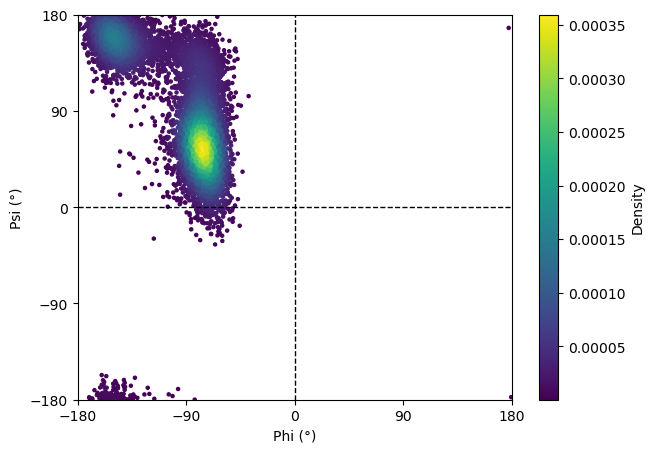

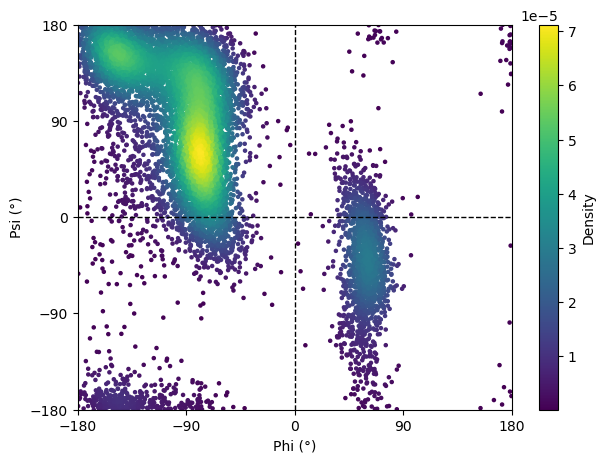

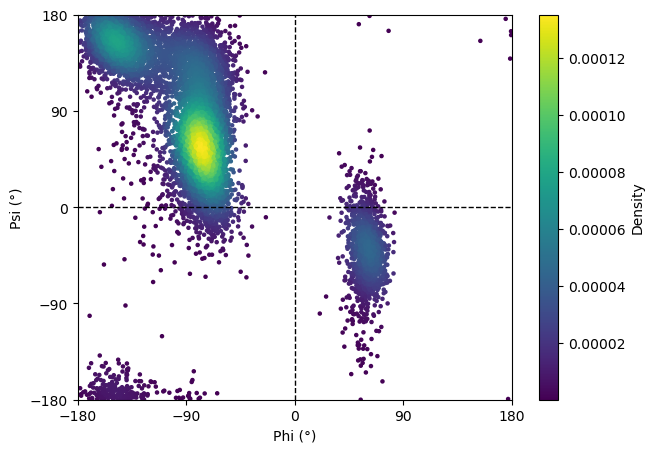

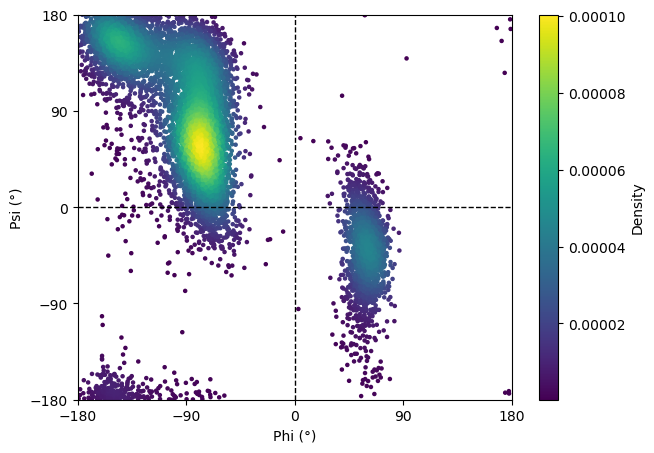

In [24]:
traj = mdtraj.load("traj_openmm_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
data = plot_ramachandran_contour(traj, 'unbiased')
traj = mdtraj.load("traj_openmm_gad_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
data = plot_ramachandran_contour(traj, 'GADES')
traj = mdtraj.load("traj_openmm_gad_mem10_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
data = plot_ramachandran_contour(traj, 'GADES (w/ mem. 10)')
traj = mdtraj.load("traj_openmm_gad_mem5_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
data = plot_ramachandran_contour(traj, 'GADES (w/ mem. 5)')


# $\kappa = 2$

In [7]:
# Create the system
system = forcefield.createSystem(prmtop.topology, nonbondedCutoff=3 * unit.nanometer, constraints=app.HBonds)

# Create a custom external force to apply biased forces
biased_force = CustomExternalForce("fx*x+fy*y+fz*z")
biased_force.addPerParticleParameter("fx")  # Add fx as a per-particle parameter
biased_force.addPerParticleParameter("fy")  # Add fy as a per-particle parameter
biased_force.addPerParticleParameter("fz")  # Add fz as a per-particle parameter
system.addForce(biased_force)

# Add a particle for each atom in the system
# Initialize with zero forces
for i in range(system.getNumParticles()):
    biased_force.addParticle(i, [0.0, 0.0, 0.0])  # fx, fy, fz initialized to 0

# Create the integrator and simulation
integrator = LangevinMiddleIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtoseconds)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

# Minimize the energy
simulation.minimizeEnergy()

In [8]:
# set step count to zero
simulation.context.setStepCount(0)
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj_openmm_gad_kappa2_2ns.dcd", 100))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter("scalars_gad_kappa2_2ns.csv", 100, time=True, potentialEnergy=True, totalEnergy=True, temperature=True))
bias_reporter = ForceUpdaterReporter(simulation, biased_force, gad_force_vec, grad_fun=grad_vec, hess_fun=hessian_vec, kappa=2.0, memory_len=1, interval=100)
simulation.reporters.append(bias_reporter)

start = time.time()
simulation.step(1e6)
end = time.time()
# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation
np.savetxt('time_openmm_gad_kappa2_2ns.dat', np.array([end-start]))

#"Step","Temperature (K)","Elapsed Time (s)"
1000,358.928327027201,6.413459777832031e-05
2000,684.8145427286635,1.5054738521575928
3000,616.331605218883,3.0387778282165527
4000,384.10767275254335,4.531292915344238
5000,266.0210634604968,6.108927965164185
6000,446.7084047143865,7.732594966888428
7000,646.2325924132418,9.280856847763062
8000,378.54682783473004,10.738926887512207
9000,610.2221297389491,12.163892030715942
10000,926.8033086306981,13.583997011184692
11000,878.8243679153995,15.04201602935791
12000,684.1421729653375,16.51585578918457
13000,366.02807933552145,18.074047088623047
14000,719.2022742178307,19.564414978027344
15000,593.3862509265118,20.983224868774414
16000,401.03829072242274,22.37566089630127
17000,344.0130989971174,23.87487483024597
18000,405.04038995600325,25.321552991867065
19000,534.2378719403176,26.84866213798523
20000,693.759543632227,28.354315042495728
21000,815.2567686013291,29.855030059814453
22000,511.3664216280207,31.292045831680298
23000,910.295209995300

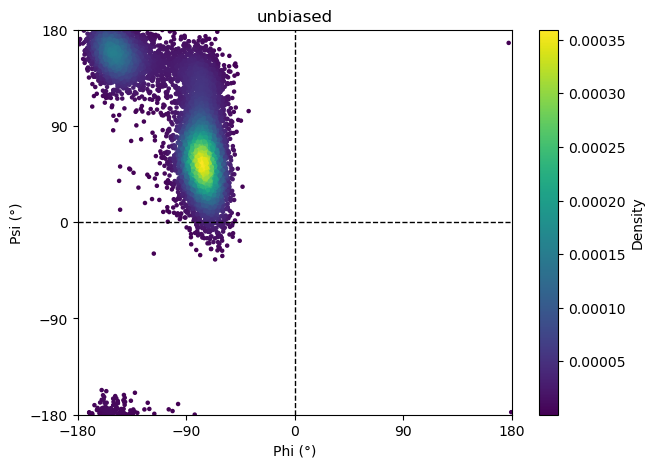

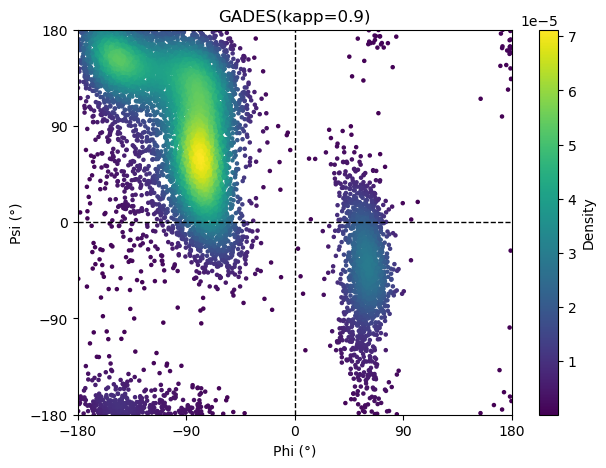

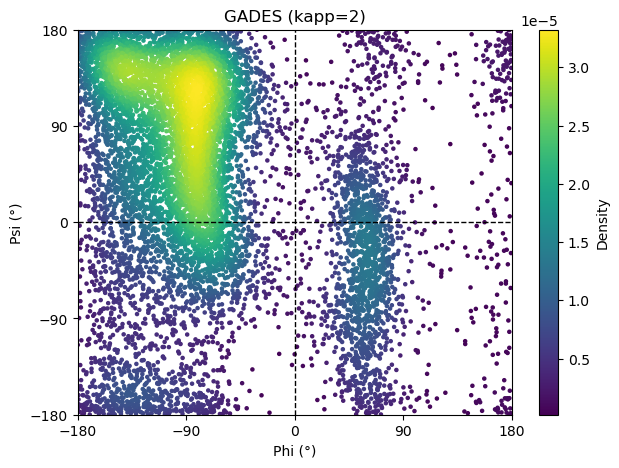

In [11]:
traj = mdtraj.load("traj_openmm_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
data = plot_ramachandran_contour(traj, 'unbiased')
traj = mdtraj.load("traj_openmm_gad_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
data = plot_ramachandran_contour(traj, 'GADES(kapp=0.9)')
traj = mdtraj.load("traj_openmm_gad_kappa2_2ns.dcd", top=f"{path}/alanine-dipeptide.prmtop")
data = plot_ramachandran_contour(traj, 'GADES (kapp=2)')
